<a href="https://colab.research.google.com/github/agargya123/options_pricing_prediction/blob/main/V10_DSO_530_Project_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import BaseEstimator, RegressorMixin

In [ ]:
uploaded = files.upload()

Saving option_train.csv to option_train.csv


In [ ]:
train_data = pd.read_csv(io.BytesIO(uploaded['option_train.csv']))
train_data.head()

,Unnamed: 0,Value,S,K,tau,r,BS
0,1,348.500,1394.46,1050,0.128767,0.0116,Under
1,2,149.375,1432.25,1400,0.679452,0.0113,Under
2,3,294.500,1478.90,1225,0.443836,0.0112,Under
3,4,3.375,1369.89,1500,0.117808,0.0119,Over
4,5,84.000,1366.42,1350,0.298630,0.0119,Under


In [ ]:
uploaded1 = files.upload()

Saving option_test_nolabel.csv to option_test_nolabel.csv


In [ ]:
test_data = pd.read_csv(io.BytesIO(uploaded1['option_test_nolabel.csv']))
test_data.head()

,Unnamed: 0,S,K,tau,r
0,1,1409.28,1325,0.126027,0.0115
1,2,1505.97,1100,0.315068,0.0110
2,3,1409.57,1450,0.197260,0.0116
3,4,1407.81,1250,0.101370,0.0116
4,5,1494.50,1300,0.194521,0.0110


In [ ]:
# Check for missing values on train
train_data = train_data[['Value','S', 'K', 'r', 'tau']]
missing_values = train_data.isna().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Value    0
S        0
K        0
r        0
tau      0
dtype: int64


In [ ]:
# Check for missing values on test
test_data = test_data[['S', 'K', 'r', 'tau']]
missing_values = test_data.isna().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
S      0
K      0
r      0
tau    0
dtype: int64


In [ ]:
test_data.shape

(500, 4)

<Figure size 1200x800 with 0 Axes>

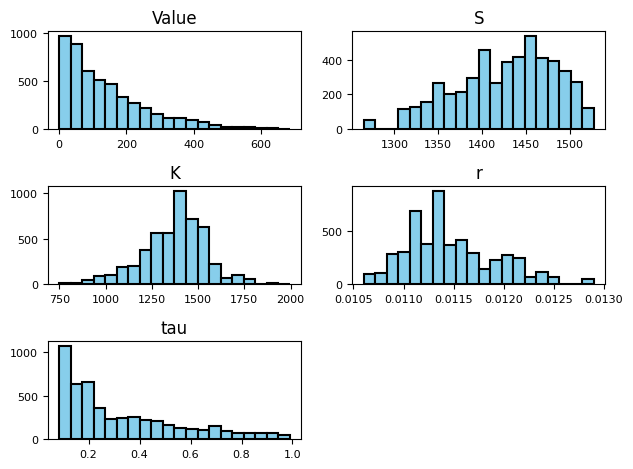

In [ ]:
# Plot histograms for each column
plt.figure(figsize=(12, 8))
train_data.hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.5, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

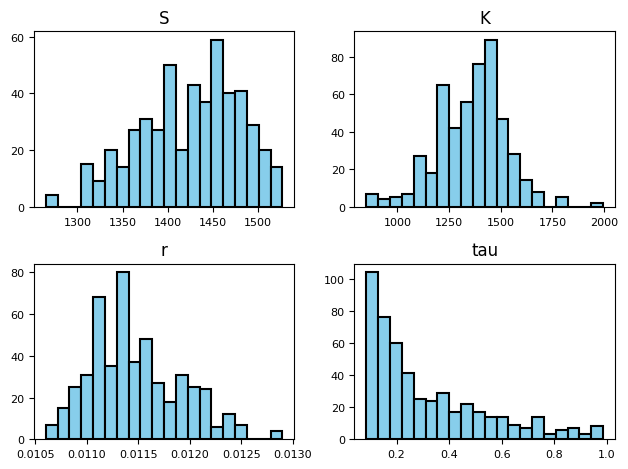

In [ ]:
# Plot histograms for each column in test data
plt.figure(figsize=(12, 8))
test_data.hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.5, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout()
plt.show()

In [ ]:
# Define target variable
target_variable = 'Value'

# Define feature columns
feature_columns = ['S', 'K', 'r', 'tau']

# Create separate scalers for target and features
scaler_target = StandardScaler()
scaler_features = StandardScaler()

# Scale target variable
train_data[target_variable] = scaler_target.fit_transform(train_data[[target_variable]])

# Scale features
train_data[feature_columns] = scaler_features.fit_transform(train_data[feature_columns])

# Combine scaled target and features
train_data_scaled = train_data

# Print the scaled DataFrame head
print(train_data_scaled.head())


      Value         S         K         r       tau
0  1.663569 -0.574242 -1.854747  0.295313 -0.860212
1  0.072383  0.100027  0.172337 -0.373826  1.522042
2  1.232061  0.932380 -0.841205 -0.596872  0.502769
3 -1.094288 -1.012632  0.751504  0.964453 -0.907620
4 -0.450022 -1.074546 -0.117247  0.964453 -0.125387


In [ ]:
# Calculate the z-scores for each data point in each column
z_scores = stats.zscore(train_data_scaled)

# Define a threshold for identifying outliers (e.g., 3 standard deviations)
threshold = 3

# Find outliers based on the absolute z-scores exceeding the threshold
outliers = (abs(z_scores) > threshold).any(axis=1)

# Remove outliers
training_data = train_data_scaled[~outliers]

# Display the shape of the DataFrame before and after removing outliers
print("Original shape:", train_data_scaled.shape)
print("Shape after removing outliers:", training_data.shape)
# train_data_no_outliers

Original shape: (5000, 5)
Shape after removing outliers: (4875, 5)


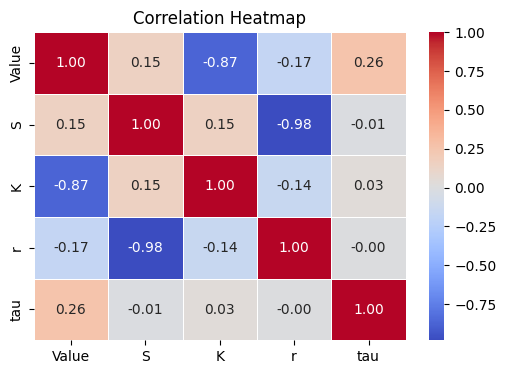

In [ ]:
# Compute correlations
correlation_matrix = training_data.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Convert feature_columns to a DataFrame
X_train_vif = training_data[feature_columns]

# Compute VIF for each variable
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns  # Use X.columns instead of X['Variable']
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for each variable
vif_result = calculate_vif(X_train_vif)
print(vif_result)

  Variable        VIF
0        S  30.231781
1        K   1.031387
2        r  30.085366
3      tau   1.006089


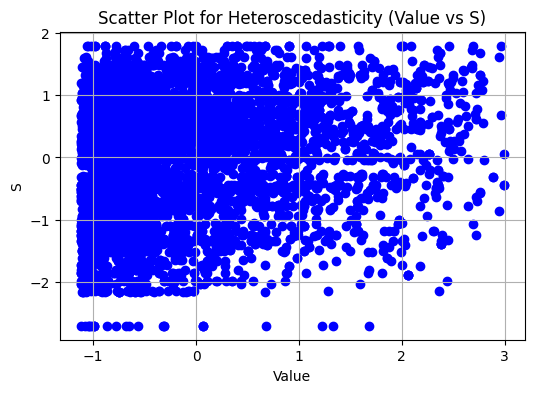

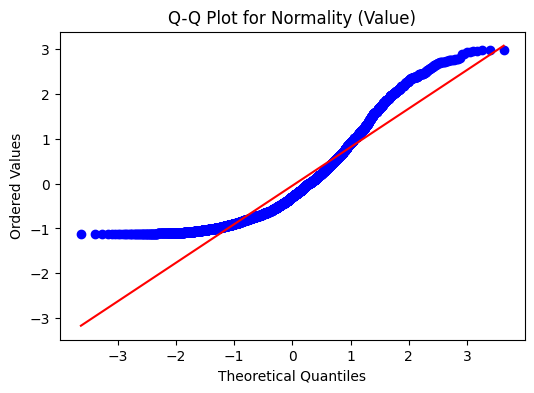

In [ ]:
# Plot heteroscedasticity for 'Value' and 'S'
plt.figure(figsize=(6, 4))
plt.scatter(training_data['Value'], training_data['S'], color='blue')
plt.title('Scatter Plot for Heteroscedasticity (Value vs S)')
plt.xlabel('Value')
plt.ylabel('S')
plt.grid(True)
plt.show()

# Plot normality using Q-Q plot for 'Value'
plt.figure(figsize=(6, 4))
stats.probplot(training_data['Value'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality (Value)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [ ]:
X = training_data[['S', 'K', 'r', 'tau']]  # Features
y = training_data['Value']  # Target variable

In [ ]:
# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Linear Models
(LinearRegression, Ridge, Lasso, ElasticNet)
Predicted Value using Ridge

### OLS

In [ ]:
# Add constant term for intercept
constant = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, constant).fit()

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.685e+04
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:50:52   Log-Likelihood:                 123.38
No. Observations:                4875   AIC:                            -236.8
Df Residuals:                    4870   BIC:                            -204.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0180      0.003     -5.329      0.0

### Linear Regression

In [ ]:
# Step 2: Create a LinearRegression object and fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate the R-squared value on the testing data
r_squared_test = model.score(X_test, y_test)
print("Out-of-sample R-squared:", r_squared_test)

# Make predictions on the test set
y_pred1 = model.predict(X_test)

# Residuals
residuals1 = y_test - y_pred1

# Residual sum of squares
rss1 = np.sum(residuals1 ** 2)

# AIC
aic = n * np.log(rss1 / n) + 2 * p

# BIC
bic = n * np.log(rss1 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Out-of-sample R-squared: 0.9329217216356855
AIC: -2833.1667194350384
BIC: -2813.636969551047


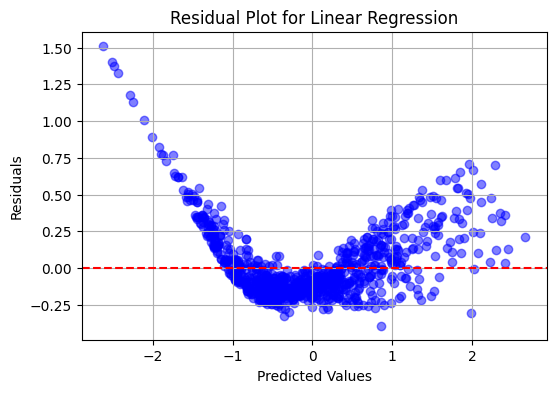

In [ ]:
# Step 5: Plot residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred1, residuals1, color='blue', alpha=0.5)
plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Create a LinearRegression object
model1 = LinearRegression()

# Assuming X is your independent variables and y is your dependent variable
# Fit the model to your data
model1.fit(X, y)
r_squared = model1.score(X, y)
print("R-squared:",r_squared)

# Number of samples
n = len(y)
# Number of predictors (features)
p = X.shape[1]
# Calculate the adjusted R-squared value
adjusted_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

print("Adjusted R-squared:", adjusted_r_squared)

R-squared: 0.9326181212677704
Adjusted R-squared: 0.9325627768088528


In [ ]:
# Perform cross-validation
scores = cross_val_score(model1, X, y, cv=10, scoring='r2')

# Print the R-squared scores for each fold
print("R-squared scores for each fold:", scores)

# Calculate and print the mean R-squared score across all folds
print("Mean R-squared:", scores.mean())

R-squared scores for each fold: [0.92367745 0.94185283 0.93009856 0.940522   0.93608045 0.94359324
 0.91599188 0.91631364 0.94028445 0.92731863]
Mean R-squared: 0.9315733143022904


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = model1.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

# Handle negative predictions (optional)
predicted_values_clipped = predicted_values_original_scale.copy()
predicted_values_clipped[predicted_values_clipped < 0] = 0.275060  # Set negatives to a small positive value

predicted_values_df = pd.DataFrame(predicted_values_clipped, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,128.394409,1409.28,1325,0.0115,0.126027
1,363.295404,1505.97,1100,0.0110,0.315068
2,55.423603,1409.57,1450,0.0116,0.197260
3,172.869543,1407.81,1250,0.0116,0.101370
4,206.571969,1494.50,1300,0.0110,0.194521


### Ridge Regression

In [ ]:
# Step 2: Create and fit the Ridge Regression model to the training data
alpha = 10  # Choose an appropriate value for alpha
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

# Calculate the R-squared value on the testing data
r_squared_test =ridge_model.score(X_test, y_test)
print("Out-of-sample R-squared:", r_squared_test)

# Step 3: Predict on the test data
y_pred2 = ridge_model.predict(X_test)

# Step 4: Calculate residuals
residuals2 = y_test - y_pred2

# Residual sum of squares
rss2 = np.sum(residuals2 ** 2)

# AIC
aic = n * np.log(rss2 / n) + 2 * p

# BIC
bic = n * np.log(rss2 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Out-of-sample R-squared: 0.9329324849136602
AIC: -22044.625718101743
BIC: -22018.658216568016


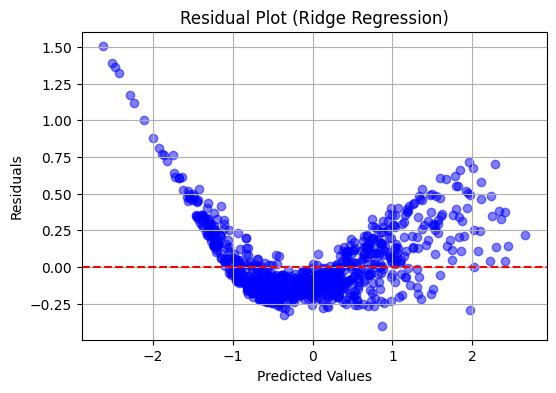

In [ ]:
# Step 5: Plot residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred2, residuals2, color='blue', alpha=0.5)
plt.title('Residual Plot (Ridge Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# 2. Ridge Regression
ridge_model = Ridge(alpha=10)  # Choose an appropriate value for alpha
ridge_model.fit(X, y)

# Calculate R-squared for Ridge model
ridge_train_r2 = ridge_model.score(X, y)

# Number of samples
n = len(y)
# Number of predictors (features)
p = X.shape[1]

# Calculate R-squared for Ridge model
ridge_train_r2 = ridge_model.score(X, y)
print("\nRidge Training R-squared:", ridge_train_r2)

# Calculate the adjusted R-squared value
adjusted_r_squared = 1 - (1 - ridge_train_r2) * ((n - 1) / (n - p - 1))
print("Adjusted R-squared:", adjusted_r_squared)


Ridge Training R-squared: 0.9326049104693773
Adjusted R-squared: 0.9325495551597013


In [ ]:
num_folds = 10
kf = KFold(n_splits=num_folds)

# Perform cross-validation to select the best alpha for Ridge regression
alphas = np.linspace(0.1, 10, 20)  # Test 20 alphas from 0.1 to 10
ridge_cv = RidgeCV(alphas=alphas, cv=kf)  # Use the defined number of folds
ridge_cv.fit(X, y)

# Print the selected alpha
print("Optimal alpha selected by RidgeCV:", ridge_cv.alpha_)

# Perform cross-validation and calculate R-squared for each fold
r2_scores = cross_val_score(ridge_cv, X, y, cv=kf, scoring='r2')

# Print R-squared for each fold
for i, r2_score_fold in enumerate(r2_scores):
    print(f"R-squared for Fold {i+1}: {r2_score_fold}")

# Calculate the average R-squared value
avg_r2 = np.mean(r2_scores)

print("Average R-squared across all folds:", avg_r2)

Optimal alpha selected by RidgeCV: 3.2263157894736847
R-squared for Fold 1: 0.9236887295401952
R-squared for Fold 2: 0.9418356700639345
R-squared for Fold 3: 0.9300769007342765
R-squared for Fold 4: 0.9405468686682916
R-squared for Fold 5: 0.9360476099995365
R-squared for Fold 6: 0.9434699657595986
R-squared for Fold 7: 0.916022867502689
R-squared for Fold 8: 0.9164598160002625
R-squared for Fold 9: 0.9402544511438357
R-squared for Fold 10: 0.9273282480420832
Average R-squared across all folds: 0.9315731127454704


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = ridge_model.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

# Handle negative predictions (optional)
predicted_values_clipped = predicted_values_original_scale.copy()
predicted_values_clipped[predicted_values_clipped < 0] = 0.275060  # Set negatives to a small positive value

predicted_values_df = pd.DataFrame(predicted_values_clipped, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,128.809328,1409.28,1325,0.0115,0.126027
1,362.056004,1505.97,1100,0.0110,0.315068
2,55.653011,1409.57,1450,0.0116,0.197260
3,172.825195,1407.81,1250,0.0116,0.101370
4,206.117132,1494.50,1300,0.0110,0.194521


### Lasso Regression

In [ ]:
# Step 2: Create and fit the Lasso Regression model to the training data
alpha = 0.01  # Choose an appropriate value for alpha
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Calculate the R-squared value on the testing data
r_squared_test = lasso_model.score(X_test, y_test)
print("Out-of-sample R-squared:", r_squared_test)

# Step 3: Predict on the test data
y_pred3 = lasso_model.predict(X_test)

# Step 4: Calculate residuals
residuals3 = y_test - y_pred3

# Residual sum of squares
rss3 = np.sum(residuals3 ** 2)

# AIC
aic = n * np.log(rss3 / n) + 2 * p

# BIC
bic = n * np.log(rss3 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Out-of-sample R-squared: 0.9324607688544418
AIC: -22010.457665357542
BIC: -21984.490163823815


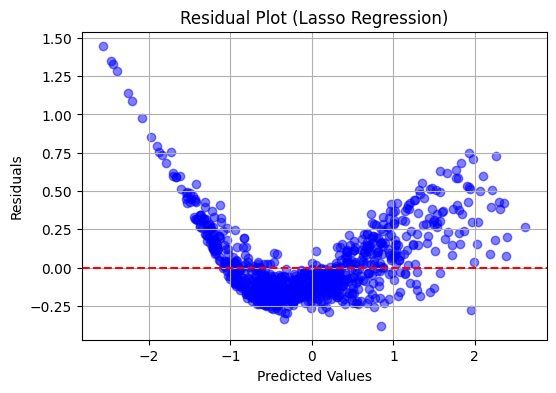

In [ ]:
# Step 5: Plot residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred3, residuals3, color='blue', alpha=0.5)
plt.title('Residual Plot (Lasso Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Create a Lasso object
lasso_model = Lasso(alpha=0.01)  # Choose an appropriate value for alpha

# Fit the Lasso model to your data
lasso_model.fit(X, y)

# Calculate R-squared for Lasso model
lasso_train_r2 = lasso_model.score(X, y)

# Number of samples
n = len(y)
# Number of predictors (features)
p = X.shape[1]

print("\nLasso Training R-squared:", lasso_train_r2)

adjusted_r_squared = 1 - (1 - lasso_train_r2) * ((n - 1) / (n - p - 1))

print("Adjusted R-squared:", adjusted_r_squared)


Lasso Training R-squared: 0.9321614792061215
Adjusted R-squared: 0.9321057596818555


In [ ]:
alphas = np.linspace(0.01, 10, 20)
lasso_cv = LassoCV(alphas=alphas, cv=10)  # Use the defined number of folds
lasso_cv.fit(X, y)

# Print the selected alpha
print("Optimal alpha selected by LassoCV:", lasso_cv.alpha_)

# Perform cross-validation and calculate R-squared for each fold
r2_scores = cross_val_score(lasso_cv, X, y, cv=10, scoring='r2')

# Print R-squared for each fold
for i, r2_score_fold in enumerate(r2_scores):
    print(f"R-squared for Fold {i+1}: {r2_score_fold}")

# Calculate the average R-squared value
avg_r2 = np.mean(r2_scores)

print("Average R-squared across all folds:", avg_r2)

Optimal alpha selected by LassoCV: 0.01
R-squared for Fold 1: 0.9232945976794413
R-squared for Fold 2: 0.9409759906630477
R-squared for Fold 3: 0.9297344609101521
R-squared for Fold 4: 0.9395718475070922
R-squared for Fold 5: 0.9354509180938885
R-squared for Fold 6: 0.941782757141679
R-squared for Fold 7: 0.91677370011032
R-squared for Fold 8: 0.9177326117005479
R-squared for Fold 9: 0.9394404914156589
R-squared for Fold 10: 0.926827898133116
Average R-squared across all folds: 0.9311585273354943


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = lasso_model.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

# Handle negative predictions (optional)
predicted_values_clipped = predicted_values_original_scale.copy()
predicted_values_clipped[predicted_values_clipped < 0] = 0.275060  # Set negatives to a small positive value

predicted_values_df = pd.DataFrame(predicted_values_clipped, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,129.638371,1409.28,1325,0.0115,0.126027
1,358.115581,1505.97,1100,0.0110,0.315068
2,57.440614,1409.57,1450,0.0116,0.197260
3,173.434404,1407.81,1250,0.0116,0.101370
4,204.575808,1494.50,1300,0.0110,0.194521


### Elastic Net Regression

In [ ]:
alpha = 0.01  # Choose an appropriate value for alpha
l1_ratio = 0.5  # Choose a value for the mixing parameter l1_ratio (0.5 for equal L1 and L2 penalty)
elasticnet_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elasticnet_model.fit(X_train, y_train)

# Calculate the R-squared value on the testing data
r_squared_test = elasticnet_model.score(X_test, y_test)
print("Out-of-sample R-squared:", r_squared_test)

# Step 3: Predict on the test data
y_pred4 = elasticnet_model.predict(X_test)

# Step 4: Calculate residuals
residuals4 = y_test - y_pred4

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss4 = np.sum(residuals4 ** 2)

# AIC
aic = n * np.log(rss4 / n) + 2 * p

# BIC
bic = n * np.log(rss4 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Out-of-sample R-squared: 0.9326711131594057
AIC: -2829.5308485771575
BIC: -2810.001098693166


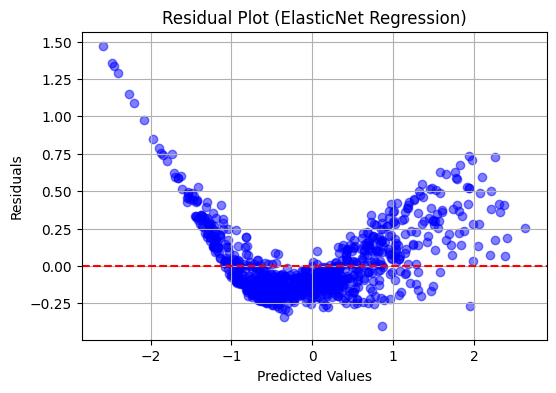

In [ ]:
# Step 5: Plot residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred4, residuals4, color='blue', alpha=0.5)
plt.title('Residual Plot (ElasticNet Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Create an ElasticNet model object
elasticnet_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # Specify alpha and l1_ratio

# Fit the ElasticNet model to your data
elasticnet_model.fit(X, y)

# Calculate R-squared for ElasticNet model
elasticnet_train_r2 = elasticnet_model.score(X, y)

# Number of samples
n = len(y)
# Number of predictors (features)
p = X.shape[1]

print("\nLasso Training R-squared:", elasticnet_train_r2)

adjusted_r_squared = 1 - (1 - elasticnet_train_r2) * ((n - 1) / (n - p - 1))

print("Adjusted R-squared:", adjusted_r_squared)


Lasso Training R-squared: 0.9326147014015375
Adjusted R-squared: 0.9325593541336947


In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(elasticnet_model, X, y, cv=10, scoring='r2')  # 5-fold cross-validation

# Print R-squared for each fold
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1} R-squared: {score}")

# Calculate the average R-squared value
avg_r2 = np.mean(cv_scores)

print("Average R-squared across all folds:", avg_r2)

Fold 1 R-squared: 0.9236870715278357
Fold 2 R-squared: 0.9418199055606509
Fold 3 R-squared: 0.930084485916251
Fold 4 R-squared: 0.9405152492451087
Fold 5 R-squared: 0.9360567359011397
Fold 6 R-squared: 0.9434571455052319
Fold 7 R-squared: 0.916075042237094
Fold 8 R-squared: 0.9164779373890783
Fold 9 R-squared: 0.9402559735054397
Fold 10 R-squared: 0.927318099725463
Average R-squared across all folds: 0.9315747646513293


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = elasticnet_model.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

# Handle negative predictions (optional)
predicted_values_clipped = predicted_values_original_scale.copy()
predicted_values_clipped[predicted_values_clipped < 0] = 0.275060  # Set negatives to a small positive value

predicted_values_df = pd.DataFrame(predicted_values_clipped, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,128.584900,1409.28,1325,0.0115,0.126027
1,362.688828,1505.97,1100,0.0110,0.315068
2,55.583039,1409.57,1450,0.0116,0.197260
3,172.891631,1407.81,1250,0.0116,0.101370
4,206.341563,1494.50,1300,0.0110,0.194521


In [ ]:
# Try log transformation

# Non-Linear Models
(SVR, LightGBM, Random Forest, Neural Network(Sequential))

### SVR

In [ ]:
# Define a range of values for the regularization parameter C
param_grid = {'C': [0.1, 1, 10, 100]}  # Adjust the range as needed

# Create SVR model
svr_model = SVR(kernel='rbf')  # Example with RBF kernel

# Perform grid search to find the best value of C
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best value of C
best_C = grid_search.best_params_['C']
print("Best value of C:", best_C)

# Step 2: Create and fit the SVR model to the training data
svr_model = SVR(kernel='rbf', C=best_C)  # You can choose different kernels such as 'linear', 'poly', or 'sigmoid'
svr_model.fit(X_train, y_train)

# Step 3: Predict on the test data
y_pred5 = svr_model.predict(X_test)

# Step 4: Calculate residuals
residuals5 = y_test - y_pred5

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss5 = np.sum(residuals5 ** 2)

# AIC
aic = n * np.log(rss5 / n) + 2 * p

# BIC
bic = n * np.log(rss5 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Best value of C: 10
AIC: -5739.0065737431305
BIC: -5719.476823859139


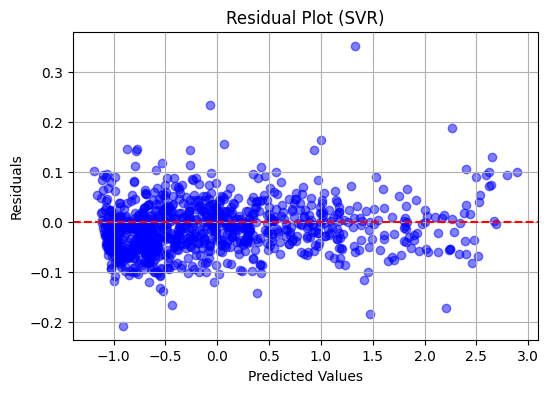

In [ ]:
# Step 5: Plot residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred5, residuals5, color='blue', alpha=0.5)
plt.title('Residual Plot (SVR)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Create SVR model with the best value of C
best_svr_model = SVR(kernel='rbf', C=best_C)
best_svr_model.fit(X, y)

# Calculate R-squared
r_squared = best_svr_model.score(X, y)
print("R-squared:", r_squared)

# Perform 5-fold cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds)
r_squared_scores = cross_val_score(best_svr_model, X, y, cv=10, scoring='r2')

# Print R-squared for each fold
for i, r2_score_fold in enumerate(r_squared_scores):
    print(f"R-squared for Fold {i+1}: {r2_score_fold}")

# Calculate the average R-squared value
avg_r2 = np.mean(r_squared_scores)

print("Average R-squared across all folds:", avg_r2)

R-squared: 0.9968197875271944
R-squared for Fold 1: 0.9961233993932127
R-squared for Fold 2: 0.996758041666579
R-squared for Fold 3: 0.9966284139540349
R-squared for Fold 4: 0.9967340845591067
R-squared for Fold 5: 0.996756222176403
R-squared for Fold 6: 0.9967447042661496
R-squared for Fold 7: 0.9960607871196832
R-squared for Fold 8: 0.9960006214818912
R-squared for Fold 9: 0.9964273810914566
R-squared for Fold 10: 0.996144529394285
Average R-squared across all folds: 0.9964378185102802


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = best_svr_model.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

predicted_values_df = pd.DataFrame(predicted_values_original_scale, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,107.812614,1409.28,1325,0.0115,0.126027
1,428.478339,1505.97,1100,0.0110,0.315068
2,44.899597,1409.57,1450,0.0116,0.197260
3,173.570331,1407.81,1250,0.0116,0.101370
4,216.897366,1494.50,1300,0.0110,0.194521


### Decision Tree Regression

In [ ]:
# Define a range of values for ccp_alpha
ccp_alphas = np.linspace(0, 0.1, 50)  # Adjust the range as needed

# Initialize lists to store mean squared errors for each alpha
mse_scores = []

# Perform cross-validation for each alpha
for alpha in ccp_alphas:
    dt_regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    # Perform cross-validation with 5 folds
    scores = cross_val_score(dt_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())  # Negate the scores to get positive MSE values

# Find the alpha with the lowest mean squared error
best_alpha = ccp_alphas[np.argmin(mse_scores)]
print("Best alpha:", best_alpha)

Best alpha: 0.0


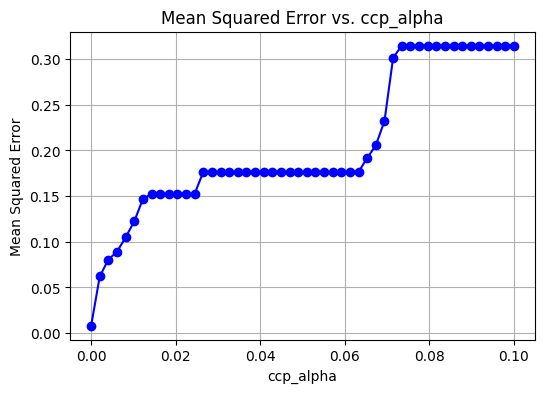

In [ ]:
# Plot mean squared errors for each alpha
plt.figure(figsize=(6, 4))
plt.plot(ccp_alphas, mse_scores, color='blue', marker='o', linestyle='-')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. ccp_alpha')
plt.grid(True)
plt.show()

R-squared: 0.9913206191806146
AIC: -4826.954046713769
BIC: -4807.424296829777


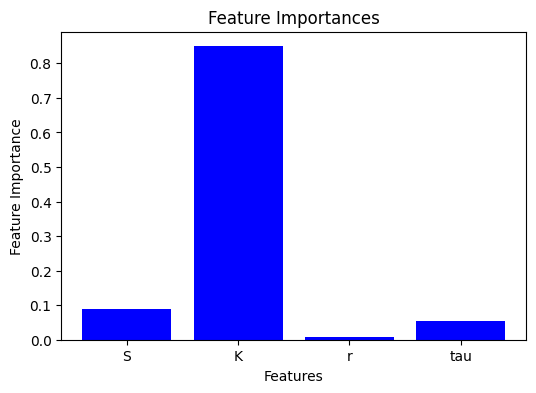

In [ ]:
# Create and fit the DecisionTreeRegressor model with CCP pruning
dt_regressor_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=0.0)
dt_regressor_pruned.fit(X_train, y_train)

# Make predictions on the test data
y_pred6 = dt_regressor_pruned.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred6)
print("R-squared:", r2)

# Step 4: Calculate residuals
residuals6 = y_test - y_pred6

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss6 = np.sum(residuals6 ** 2)

# AIC
aic = n * np.log(rss6 / n) + 2 * p

# BIC
bic = n * np.log(rss6 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

# Plot feature importances
plt.figure(figsize=(6, 4))
plt.bar(range(len(dt_regressor_pruned.feature_importances_)), dt_regressor_pruned.feature_importances_, color='blue')
plt.xticks(range(len(dt_regressor_pruned.feature_importances_)), X.columns)  # Use column names of X
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
dt_regressor_pruned1 = DecisionTreeRegressor(random_state=42, ccp_alpha=0.0)
dt_regressor_pruned1.fit(X, y)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(dt_regressor_pruned1, X, y, cv=10, scoring='r2')

# Print R-squared for each fold
print("R-squared for each fold:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score}")

# Calculate the mean R-squared across all folds
mean_cv_score = np.mean(cv_scores)
print("Mean R-squared:", mean_cv_score)

R-squared for each fold:
Fold 1: 0.9905789346771106
Fold 2: 0.9922442812391314
Fold 3: 0.9944312834334981
Fold 4: 0.991970324458493
Fold 5: 0.991112149151413
Fold 6: 0.993423099813293
Fold 7: 0.9899103566774752
Fold 8: 0.9924647467406129
Fold 9: 0.9922848911684559
Fold 10: 0.9936683802645743
Mean R-squared: 0.9922088447624058


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = dt_regressor_pruned1.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

predicted_values_df = pd.DataFrame(predicted_values_original_scale, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,117.375,1409.28,1325,0.0115,0.126027
1,422.750,1505.97,1100,0.0110,0.315068
2,35.000,1409.57,1450,0.0116,0.197260
3,185.000,1407.81,1250,0.0116,0.101370
4,214.500,1494.50,1300,0.0110,0.194521


### Random Forest Regression

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],  # Adjust the range as needed
    'min_samples_split': [2, 5, 10]  # Adjust the values as needed
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_regressor = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred7 = best_rf_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred7)
print("R-squared on Validation Set:", r2)

# Step 4: Calculate residuals
residuals7 = y_test - y_pred7

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss7 = np.sum(residuals7 ** 2)

# AIC
aic = n * np.log(rss7 / n) + 2 * p

# BIC
bic = n * np.log(rss7 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 2}
R-squared on Validation Set: 0.9934946692346448
AIC: -5108.074074298194
BIC: -5088.5443244142025


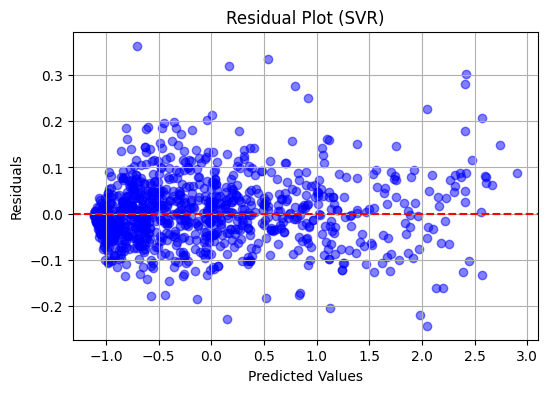

In [ ]:
# Plot Residuals
residuals7 = y_test - y_pred7

plt.figure(figsize=(6, 4))
plt.scatter(y_pred7, residuals7, color='blue', alpha=0.5)
plt.title('Residual Plot (SVR)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=9, min_samples_split=2)
rf_regressor.fit(X, y)

# Cross Validation
cv_scores = cross_val_score(rf_regressor, X, y, cv=10, scoring='r2')

print("R-squared for each fold:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score}")

mean_r2 = np.mean(cv_scores)
print("Mean R-squared (Cross-Validation):", mean_r2)

R-squared for each fold:
Fold 1: 0.9926140675801713
Fold 2: 0.9931683777278222
Fold 3: 0.994753653958063
Fold 4: 0.9928984436356943
Fold 5: 0.9937790558936083
Fold 6: 0.9942271611132211
Fold 7: 0.9938553819465904
Fold 8: 0.9931712586008217
Fold 9: 0.9934393175573589
Fold 10: 0.9938664150045119
Mean R-squared (Cross-Validation): 0.9935773133017862


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

predicted_values = rf_regressor.predict(test_data_scaled)
# Assuming 'Value' is the target variable column
predicted_values_original_scale =scaler_target.inverse_transform(predicted_values.reshape(-1, 1))[:, 0]

predicted_values_df = pd.DataFrame(predicted_values_original_scale, columns=['Value'])

# Combine features and target in a DataFrame
combined_df = pd.concat([predicted_values_df, pd.DataFrame(test_data)], axis=1)
combined_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,Value,S,K,r,tau
0,113.282094,1409.28,1325,0.0115,0.126027
1,428.541718,1505.97,1100,0.0110,0.315068
2,47.057401,1409.57,1450,0.0116,0.197260
3,190.021943,1407.81,1250,0.0116,0.101370
4,220.658802,1494.50,1300,0.0110,0.194521


### Gradient Boosting Regression

In [ ]:
# Define the parameter grid including hyperparameters to experiment with
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],  # Experiment with different learning rates
    'num_leaves': [31, 50, 100],         # Experiment with different numbers of leaves
    'min_child_samples': [20, 50, 100]   # Experiment with different minimum child samples
}

# Initialize the LightGBM Regressor with verbose set to -1
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)

# Perform grid search with cross-validation
grid_search_lgb = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, cv=5, scoring='r2')
grid_search_lgb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_lgb = grid_search_lgb.best_params_
print("Best Hyperparameters (LightGBM):", best_params_lgb)

# Get the best model
best_lgb_regressor = grid_search_lgb.best_estimator_

# Evaluate the best model on the test set
y_pred_lgb = best_lgb_regressor.predict(X_test)
r2_lgb = r2_score(y_test, y_pred_lgb)
print("R-squared on Validation Set (LightGBM):", r2_lgb)

# Step 4: Calculate residuals
residuals8 = y_test - y_pred_lgb

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss8 = np.sum(residuals8 ** 2)

# AIC
aic = n * np.log(rss8 / n) + 2 * p

# BIC
bic = n * np.log(rss8 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Best Hyperparameters (LightGBM): {'learning_rate': 0.2, 'min_child_samples': 20, 'num_leaves': 50}
R-squared on Validation Set (LightGBM): 0.9969887412706373
AIC: -5859.081264357673
BIC: -5839.551514473681


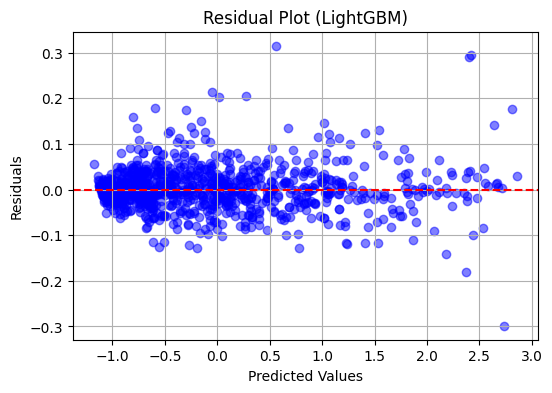

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lgb, residuals8, color='blue', alpha=0.5)
plt.title('Residual Plot (LightGBM)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, learning_rate = 0.2, min_child_samples = 20, num_leaves = 50)

# Fit the LightGBM model with best hyperparameters on the entire dataset
lgb_regressor.fit(X, y)

# Cross Validation for LightGBM
cv_scores_lgb = cross_val_score(lgb_regressor, X, y, cv=10, scoring='r2')

print("R-squared for each fold (LightGBM):")
for i, score in enumerate(cv_scores_lgb):
    print(f"Fold {i+1}: {score}")

mean_r2_lgb = np.mean(cv_scores_lgb)
print("Mean R-squared (Cross-Validation, LightGBM):", mean_r2_lgb)

R-squared for each fold (LightGBM):
Fold 1: 0.9973172333622253
Fold 2: 0.9972098331029914
Fold 3: 0.9980940715176166
Fold 4: 0.9968851262897379
Fold 5: 0.9977109300378164
Fold 6: 0.9974352908553434
Fold 7: 0.9974053655911178
Fold 8: 0.9968367618872755
Fold 9: 0.9976388570507985
Fold 10: 0.9971408141568211
Mean R-squared (Cross-Validation, LightGBM): 0.9973674283851744


In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

# Predict on the test data using the fitted LightGBM model
predicted_values_lgb = lgb_regressor.predict(test_data_scaled)

# Convert predicted values to original scale
predicted_values_original_scale_lgb = scaler_target.inverse_transform(predicted_values_lgb.reshape(-1, 1))[:, 0]

# Create a DataFrame for the predicted values
predicted_values_df_lgb = pd.DataFrame(predicted_values_original_scale_lgb, columns=['Value'])

# Combine features and predicted target values in a DataFrame
combined_df_lgb = pd.concat([predicted_values_df_lgb, pd.DataFrame(test_data)], axis=1)
combined_df_lgb.head()

,Value,S,K,r,tau
0,103.740350,1409.28,1325,0.0115,0.126027
1,428.595613,1505.97,1100,0.0110,0.315068
2,48.754323,1409.57,1450,0.0116,0.197260
3,177.678777,1407.81,1250,0.0116,0.101370
4,219.066963,1494.50,1300,0.0110,0.194521


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Assuming combined_df_lgb is your DataFrame and csv_file_name is the desired name of the CSV file
csv_file_name = 'classification_test_data.csv'
csv_file_path = os.path.join('/content/drive/My Drive', csv_file_name)

# Save the DataFrame to a CSV file
combined_df_lgb.to_csv(csv_file_path, index=False)

print("CSV file saved to:", csv_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file saved to: /content/drive/My Drive/classification_test_data.csv


### Neural Networks

In [ ]:
from keras.layers import Dropout

# Define the function to create the model
def create_model():
    # Create a Sequential model
    model = Sequential()

    # Add input layer
    model.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
    # model.add(Dropout(0.2))

    # Add hidden layers
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=50, activation='relu'))

    # Add output layer
    model.add(Dense(units=1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=-1)

    return model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model_nn = create_model()

# Evaluate the model
y_pred9 = model_nn.predict(X_test)
r2 = r2_score(y_test, y_pred9)
print("R-squared on Test Set:", r2)

y_pred9 = y_pred9.reshape(-1)

# Step 4: Calculate residuals
residuals9 = y_test - y_pred9

# Number of observations
n = len(y_test)

# Number of predictors (features)
p = X_test.shape[1]

# Residual sum of squares
rss9 = np.sum(residuals9 ** 2)

# AIC
aic = n * np.log(rss9 / n) + 2 * p

# BIC
bic = n * np.log(rss9 / n) + p * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
31/31 [==============================] - 0s 2ms/step
R-squared on Test Set: 0.9978851861370487
AIC: -6203.637853320188
BIC: -6184.108103436196


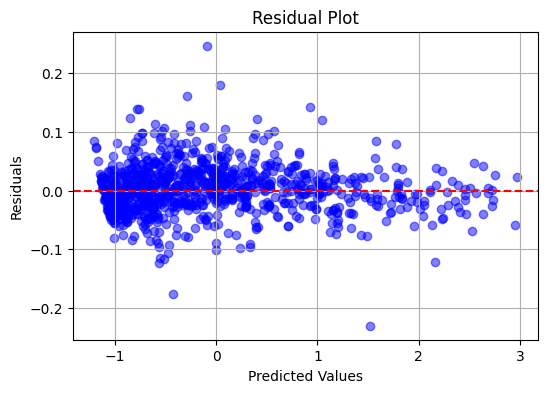

In [ ]:
# Calculate residuals
residuals = y_test - y_pred9.flatten()

# Plot residuals
plt.figure(figsize=(6, 4))
plt.scatter(y_pred9.flatten(), residuals, color='blue', alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Create an instance of the wrapper
keras_regressor = KerasRegressorWrapper(build_fn=create_model, epochs=50, batch_size=32, verbose=-1)

# Perform cross-validation
cv_scores = cross_val_score(keras_regressor, X, y, cv=10, scoring='r2')

# Print the R-squared for each fold
print("R-squared for each fold:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score}")

# Calculate and print the mean R-squared
mean_r2 = np.mean(cv_scores)
print("Mean R-squared (Cross-Validation):", mean_r2)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

In [ ]:
# Transform test data using the fitted scaler
test_data_scaled = scaler_features.transform(test_data)

# Predict on the test data using the fitted LightGBM model
predicted_values_nn = model_nn.predict(test_data_scaled)

# Convert predicted values to original scale
predicted_values_original_scale_nn = scaler_target.inverse_transform(predicted_values_nn.reshape(-1, 1))[:, 0]

# Create a DataFrame for the predicted values
predicted_values_df_nn = pd.DataFrame(predicted_values_original_scale_nn, columns=['Value'])

# Combine features and predicted target values in a DataFrame
combined_df_nn = pd.concat([predicted_values_df_nn, pd.DataFrame(test_data)], axis=1)
combined_df_nn.head()

16/16 [==============================] - 0s 2ms/step


,Value,S,K,r,tau
0,104.674301,1409.28,1325,0.0115,0.126027
1,428.957397,1505.97,1100,0.0110,0.315068
2,44.469395,1409.57,1450,0.0116,0.197260
3,171.895996,1407.81,1250,0.0116,0.101370
4,214.703232,1494.50,1300,0.0110,0.194521
